# Logistic regression in pytorch

In [11]:
import pandas as pd
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read in the data and display a few rows
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")
dat.head(4)

## Create a binary outcome variable (people will use gold lesions in HW)
m = np.median(dat.T2)
dat = dat.assign(y = (dat.T2 > m) * 1 )
## Create a normalized regression variable
dat = dat.assign(x = (dat.PD - np.mean(dat.PD)) / np.std(dat.PD))
dat.head()

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions,y,x
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0,1,1.181648
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0,1,1.426453
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0,0,-0.614749
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0,0,-0.955175
4,1.580589,1.730152,-0.860949,1.245609,0.617957,0.866352,-0.099919,0.384261,0.391133,0.608826,0.071648,0.340601,0,1,1.376909


We now perform logistic regression using PyTorch. We'll start by preparing our dataset.We read the dataset from a CSV file and display the first few rows to inspect the data structure. We create a binary outcome variable y, indicating whether the T2 value is above the median.
We normalize the PD variable and assign it to a new column x.
This preprocessing is essential for setting up our logistic regression model, ensuring the variables are in the correct format and scale for analysis.

In [12]:
fit = smf.logit('y ~ x', data = dat).fit()
print(fit.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.427855
         Iterations 7
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0367      0.269      0.136      0.892      -0.491       0.565
x              2.2226      0.436      5.095      0.000       1.368       3.078


To perform logistic regression, we'll use the statsmodels library to fit the model. We'll use the preprocessed dataset with our binary outcome variable y and normalized predictor variable x. We specify our logistic regression model.
We fit the model to the data.
Then print the second summary table, which contains the coefficients of the logistic regression model.
The summary provides important details such as the coefficients, standard errors, z-values, and p-values for the predictors. This information helps us understand the relationship between x (normalized PD) and y (binary outcome), and assess the significance of the predictor.

In [13]:
# The in sample predictions
yhat = 1 / (1 + np.exp(-fit.fittedvalues))

Next, we’ll generate in-sample predictions from our logistic regression model using the fitted values. This step transforms the linear predictions from the model into probabilities that lie between 0 and 1, which is appropriate for our binary outcome variable. These predicted probabilities help us understand the likelihood of the outcome being 1 (e.g., having a higher T2 value) given the predictor variable x.

In [14]:
n = dat.shape[0]

## Get the y and x from 
xtraining = torch.from_numpy(dat['x'].values)
ytraining = torch.from_numpy(dat['y'].values)

## PT wants floats
xtraining = xtraining.float()
ytraining = ytraining.float()

## Dimension is 1xn not nx1
## squeeze the second dimension
xtraining = xtraining.unsqueeze(1)
ytraining = ytraining.unsqueeze(1)

## Show that everything is the right size
[xtraining.shape, ytraining.shape, [n, 1] ]

[torch.Size([100, 1]), torch.Size([100, 1]), [100, 1]]

To prepare our data for logistic regression using PyTorch we need to convert it into PyTorch tensors. We convert our predictors (x) and outcomes (y) from NumPy arrays to PyTorch tensors. We ensure data type compatibility by converting to float and adjust dimensions using unsqueeze to make sure the tensors are of shape (1xn), suitable for PyTorch operations.

In [15]:
## Doing it more now the pytorch docs recommend; Example taken from 
## https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9

class LogisticRegression(torch.nn.Module): ## A class that defines the model
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias = True)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
model = LogisticRegression() ## Then the model is simply  
loss_fn = torch.nn.BCELoss()  ## MSE is the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) ## Set the optimizer
for t in range(100000):  ## Loop over iterations
  y_pred = model(xtraining)  ## Forward propagation
  loss = loss_fn(y_pred, ytraining)  ## the loss for this interation 
  optimizer.zero_grad()  ## Zero out the gradients before adding them up
  loss.backward()  ## Backprop
  optimizer.step()  ## Optimization step

To implement logistic regression using PyTorch, we define a model class LogisticRegression that inherits from torch.nn.Module. This allows us to encapsulate our model and its operations neatly. We define a LogisticRegression class where self.linear is a linear layer followed by a sigmoid activation function (torch.sigmoid) in the forward method. We use Binary Cross Entropy Loss as our loss function, suitable for binary classification tasks.
Stochastic Gradient Descent is chosen as the optimizer with specified learning rate 
During each iteration we perform forward propagation, compute the loss, backpropagate the gradients, and optimize the model parameters.
This structured approach in PyTorch allows us to efficiently train and optimize our logistic regression model.

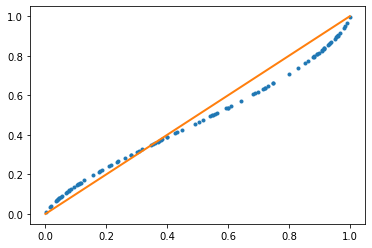

In [16]:
ytest = model(xtraining)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest,  ".")
plt.plot([0, 1], [0, 1], linewidth=2)

We're now visualizing how well our logistic regression model fits the data. yhat contains the fitted values from the logistic regression model fitted using statsmodels.
ytest contains the predictions made by our PyTorch logistic regression model after training.
Each point on the scatter plot represents a comparison between the actual value and the predicted value for each observation.
The diagonal line represents the ideal scenario where predicted values perfectly match the actual values.
Deviations from this line indicate the model's ability to predict accurately: points above the line indicate overestimation, while points below indicate underestimation.

In [17]:
for param in model.parameters():  
  print(param.data)

tensor([[1.6660]])
tensor([-0.1225])


let's examine the parameters of our trained logistic regression model in PyTorch to understand the learned weights and biases. We loop through the parameters of the model.
For each parameter, we print its data.
This will display the weights and biases that the model has learned during training. By inspecting these values, we can see how the model has adjusted the parameters to fit the data. This step is crucial for understanding the internal workings of the model and verifying that the training process has updated the parameters as expected.